# FIRST ROUGH MODEL
- SAM: At this point, I know I probably need to engineer more features in our data. But I wanted to first run a few models on our very sparse data to see if we can get any kind of significant result. If we are getting really serious nonsense, then we might need to consider pivoting. 

- We got semi-strange results. But this is also because:

    >(1) we weren't scaling the years correctly. Maybe try MinMax Scaler

    >(2) I think we should drop long lat (and eventually add things like distance_to_CBD, density_score, multi_carpark, dist_to_nearest_airbase)

In [46]:
import time
from random import randint
from onemapsg import OneMapClient
from random import randint
from geopy.distance import lonlat, distance
from math import sin, cos, sqrt, atan2, radians


import pandas as pd
import seaborn as sns
import numpy as np



import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geopy.distance import geodesic

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
#                                AutoMinorLocator)

#Creates Hi-Res PLT Plots
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


import datetime as dt

import shapely
from shapely import geometry
from shapely import ops
from shapely.geometry import Point, LineString, Polygon, MultiPoint, shape,mapping
from shapely.ops import nearest_points
from shapely.geometry import Point

from sklearn.impute import SimpleImputer

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE

#Uncomment to download Geopandas
#!pip3 install --upgrade --target=/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages geopandas
#Uncomment to download imblearn
#!pip3 install --upgrade --target=/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages imblearn

Using TensorFlow backend.
/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/samuelhe/opt/anaconda3/lib/p

In [2]:
#READING IN CSVs
stand_blocks_latlon = pd.read_csv("../data/stand_blocks_latlon.csv")
demo_blocks_latlon = pd.read_csv("../data/demo_blocks_latlon.csv")


In [3]:
demo_blocks_latlon

,year_completed,blk_no,street,bldg_contract_town,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,...,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,LONGTITUDE
0,1966.0,6,chai chee rd,bd,8.50,0.0,24.5,59.500,0.0,0.0,...,21A,CHAI CHEE ROAD,MULTI STOREY CAR PARK,21A CHAI CHEE ROAD MULTI STOREY CAR PARK SINGA...,462021,37900.929285,34300.400979,1.326474,103.922284,103.922284
1,1966.0,7,chai chee rd,bd,8.50,0.0,24.5,59.500,0.0,0.0,...,25A,CHAI CHEE ROAD,NIL,25A CHAI CHEE ROAD SINGAPORE 461025,461025,38108.592746,33948.342619,1.323290,103.924150,103.924150
2,1971.0,79,toa payoh central,tp,10.00,0.0,0.0,374.000,0.0,0.0,...,79A,TOA PAYOH CENTRAL,CENTRAL HORIZON,79A TOA PAYOH CENTRAL CENTRAL HORIZON SINGAPOR...,311079,29585.554492,35191.211349,1.334531,103.847566,103.847566
3,1973.0,89,toa payoh lorong 2,tp,10.00,0.0,0.0,198.000,0.0,0.0,...,399,LORONG 2 TOA PAYOH,OCBC TOA PAYOH LORONG 2 - ESSO STATION,399 LORONG 2 TOA PAYOH OCBC TOA PAYOH LORONG 2...,319640,29468.486588,35385.355100,1.336287,103.846514,103.846514
4,1979.0,454,ang mo kio ave 10,amk,12.00,0.0,0.0,121.000,22.0,0.0,...,444A,ANG MO KIO AVENUE 10,NIL,444A ANG MO KIO AVENUE 10 SINGAPORE 561444,561444,30376.039753,38767.520849,1.366874,103.854669,103.854669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,1979.0,516,west coast rd,cl,9.33,0.0,0.0,105.375,17.5,0.5,...,516,WEST COAST ROAD,WEST COAST PRIDE,516 WEST COAST ROAD WEST COAST PRIDE SINGAPORE...,120516,19889.910456,32276.164855,1.308168,103.760446,103.760446
171,1979.0,517,west coast rd,cl,9.33,0.0,0.0,105.375,17.5,0.5,...,517,WEST COAST ROAD,WEST COAST PRIDE,517 WEST COAST ROAD WEST COAST PRIDE SINGAPORE...,120517,19857.825213,32199.783054,1.307477,103.760157,103.760157
172,1979.0,518,west coast rd,cl,9.33,0.0,0.0,105.375,17.5,0.5,...,518,WEST COAST ROAD,WEST COAST PRIDE,518 WEST COAST ROAD WEST COAST PRIDE SINGAPORE...,120518,19722.708873,32281.695996,1.308218,103.758943,103.758943
173,1979.0,519,west coast rd,cl,9.33,0.0,0.0,105.375,17.5,0.5,...,519,WEST COAST ROAD,WEST COAST PRIDE,519 WEST COAST ROAD WEST COAST PRIDE SINGAPORE...,120519,19769.642620,32220.491106,1.307664,103.759365,103.759365


In [1]:
plt.figure(figsize=(12,8), dpi=500)


# STANDING BLOCKS AS 1200 PURPLE DOTS
sns.scatterplot(stand_blocks_latlon['LONGITUDE'], stand_blocks_latlon['LATITUDE'], marker='o', 
                hue=stand_blocks_latlon["year_completed"],
               sizes=(2, 500), palette="Purples", alpha=0.2, legend=None);

# DEMOLISHED BLOCKS AS 175 RED CROSSES
sns.scatterplot(demo_blocks_latlon['LONGITUDE'], demo_blocks_latlon['LATITUDE'], marker='P', 
                    hue=demo_blocks_latlon["year_completed"],size=demo_blocks_latlon["year_completed"],
               sizes=(50, 200), palette="Reds", alpha=0.9, legend="full");

NameError: name 'plt' is not defined

In [5]:
demo_blocks_latlon.describe()

,year_completed,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,total_dwelling_units,age_announced,num_of_blocks,is_demolished,X,Y,LATITUDE,LONGITUDE,LONGTITUDE
count,175.000000,175.000000,175.0,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.0,175.000000,175.000000,175.000000,175.000000,175.000000
mean,1967.851429,10.036343,0.0,5.565714,74.891429,23.862857,2.131429,0.057143,106.508571,40.337143,12.405714,1.0,24215.196912,32594.314599,1.311045,103.799310,103.799310
std,9.369839,3.264492,0.0,10.975371,45.695139,39.862839,5.500655,0.253060,54.065872,11.873642,10.234097,0.0,5316.909454,3232.105350,0.029230,0.047775,0.047775
min,1950.000000,3.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,18.000000,1.000000,1.0,14004.972729,28724.469189,1.276048,103.707565,103.707565
25%,1962.000000,8.000000,0.0,0.000000,41.666667,0.142857,0.000000,0.000000,74.000000,30.000000,5.000000,1.0,20759.651237,30261.215161,1.289946,103.768261,103.768261
50%,1973.000000,9.500000,0.0,0.000000,81.903226,4.923077,0.000000,0.000000,112.258065,37.000000,7.000000,1.0,24223.652518,31579.132751,1.301865,103.799386,103.799386
75%,1976.000000,12.500000,0.0,0.000000,99.333333,22.000000,1.400000,0.000000,131.857143,52.000000,21.000000,1.0,27589.791143,33714.325219,1.321173,103.829633,103.829633
max,1983.000000,17.000000,0.0,29.333333,374.000000,169.000000,25.000000,1.285714,374.000000,57.000000,31.000000,1.0,38108.592746,47059.406937,1.441867,103.924150,103.924150


In [6]:
#SINCE THE YOUNGEST BLOCK IN THE DEMOLISHED DATASET WAS BUILT IN 1983.... 
#....LETS TRY BUILDING A TRAINING SET OF ALL BLOCKS BUILT BEFORE 1984...
#....These blocks are the survivors...
survivor_blocks_latlon = stand_blocks_latlon[stand_blocks_latlon["year_completed"]<=1983]

In [7]:
#OUR UNSEEN TEST SET: WILL BE WHAT WAS BUILT FROM 1984
from1984_blocks = stand_blocks_latlon[stand_blocks_latlon["year_completed"]>1983]

In [8]:
# OUR TRAINING SET: ALL BLOCKS BUILT BEFORE 1983 (NOTE: SOME ARE DEMOLISHED)
before1984_blocks = pd.concat([survivor_blocks_latlon,demo_blocks_latlon ])

In [9]:
#DESCRIBING before1984_blocks
# Worth checking what the standard deviation for some of the room types is so high. 
before1984_blocks.describe()

,year_completed,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,total_dwelling_units,age_announced,num_of_blocks,is_demolished,X,Y,LATITUDE,LONGITUDE,LONGTITUDE
count,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000
mean,1975.122099,11.537080,0.091039,2.537308,60.750089,27.322742,11.776151,0.952160,118.380221,44.139950,10.846483,0.062478,28998.275280,34798.139695,1.330976,103.842289,103.842289
std,8.027414,5.786618,4.818187,12.068868,73.519769,44.060573,28.893248,7.524277,76.330257,8.073704,9.913591,0.242064,6993.276970,3791.985625,0.034293,0.062839,0.062839
min,1937.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,1.000000,0.000000,14004.972729,28097.635137,1.270380,103.707565,103.707565
25%,1973.000000,9.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,83.000000,39.000000,4.000000,0.000000,24267.565672,32093.189809,1.306513,103.799781,103.799781
50%,1977.000000,12.000000,0.000000,0.000000,23.000000,4.000000,0.000000,0.000000,116.000000,42.000000,7.000000,0.000000,29409.763097,34482.004614,1.328117,103.845986,103.845986
75%,1980.000000,14.000000,0.000000,0.000000,112.000000,30.000000,2.000000,0.000000,153.000000,46.000000,15.000000,0.000000,33917.064744,36945.238947,1.350391,103.886487,103.886487
max,1983.000000,27.000000,255.000000,225.000000,528.000000,316.000000,134.000000,125.000000,570.000000,83.000000,54.000000,1.000000,45292.592743,47694.700702,1.447608,103.988706,103.988706


In [10]:
#DESCRIBING from1984_blocks
from1984_blocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9574 entries, 0 to 12198
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year_completed        9574 non-null   float64
 1   blk_no                9574 non-null   object 
 2   street                9574 non-null   object 
 3   bldg_contract_town    9574 non-null   object 
 4   max_floor_lvl         9574 non-null   float64
 5   1room_sold            9574 non-null   float64
 6   2room_sold            9574 non-null   float64
 7   3room_sold            9574 non-null   float64
 8   4room_sold            9574 non-null   float64
 9   5room_sold            9574 non-null   float64
 10  exec_sold             9574 non-null   float64
 11  total_dwelling_units  9574 non-null   float64
 12  age_announced         9574 non-null   float64
 13  cluster               9574 non-null   object 
 14  num_of_blocks         9574 non-null   float64
 15  is_demolished       

## PREPPING OUR X and y

In [11]:
# LETS TRY WITHOUT DUMMIES

#before1984_blocks = pd.get_dummies(data=before1984_blocks, columns=[ "bldg_contract_town"], drop_first=True)

In [12]:
#DECIDE WHAT TO DROP, THEN GET DUMMIES FROM EVBERYTHING ELSE
#CREATING A DATAFRAME WITH ONLY NUMBERS
before1984_blocks_prep = before1984_blocks.select_dtypes(exclude=['object'])


In [13]:
#Checking out our baseline score to beat
# In our dataset, we have 6percent of our blocks built before 1984 which have been demolished
before1984_blocks_prep.is_demolished.value_counts(normalize=True)


0    0.937522
1    0.062478
Name: is_demolished, dtype: float64

In [14]:
before1984_blocks_prep.columns

Index(['year_completed', 'max_floor_lvl', '1room_sold', '2room_sold',
       '3room_sold', '4room_sold', '5room_sold', 'exec_sold',
       'total_dwelling_units', 'age_announced', 'num_of_blocks',
       'is_demolished', 'X', 'Y', 'LATITUDE', 'LONGITUDE', 'LONGTITUDE'],
      dtype='object')

In [15]:
#DEFINING OUR TARGET AND PREDICTORS
X = before1984_blocks_prep.drop('is_demolished',axis=1)
y = before1984_blocks_prep['is_demolished']

In [16]:
#PREPPING A UNSEEN DATA SET OF BLOCKS THAT WE KNOCKED DOWN ONLY AFTER 1984
from1984_blocks_prep =from1984_blocks.select_dtypes(exclude=['object'])
X_val = from1984_blocks_prep.drop('is_demolished',axis=1)

## LIGHTNING MODELLING
We're just going to dump *before1984_blocks* into a model to see if there's any kind of results we can get from there. 

In [17]:
df_list = []

In [18]:
# DEFINING A FUNCTION THAT WILL RUN MULTIPLE MODELS AND GRIDSEARCH FOR BEST PARAMETERS

def gridsearch_multi(steps_titles, steps_list, pipe_params):
    #TRAIN-TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25, stratify=y)
    # DATAFRAME TO DISPLAY RESULTS
    gs_results = pd.DataFrame(columns=['model','AUC Score', 'precision', 'recall', 
                                       'best_params', 'best score', 'confusion matrix', 
                                       'train_accuracy','test_accuracy','baseline_accuracy', 'f1-score'])

    # FOR LOOP THROUGH STEPS LIST
    for i in range(len(steps_list)):
        # INSTATIATE PIPELINE
        pipe = Pipeline(steps=steps_list[i])
        # INSTANTIATE GRIDSEARCHCV WITH PARAMETER ARGUMENT
        gs = GridSearchCV(pipe, pipe_params[i], cv=3) 
        gs.fit(X_train, y_train)
        
        #GETTING PREDICTIONS FROM MODEL
        pred = gs.predict(X_test)
        
        # DEFINE CONFUSION MATRIX ELEMENTS
        tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel() 
        
        #CALCULATING AREA UNDER THE CURVE 
        auc = roc_auc_score(y_test, pred)
        recall=tp/(tp+fp)
        precision=tp/(tn+tp)
        #DEFINE DATAFRAME COLUMNS
        model_results = {}
        model_results['model'] = steps_titles[i]
        model_results['AUC Score'] = auc
        model_results['recall (sensitivity)']= recall
        model_results['best params'] = gs.best_params_
        model_results['best score'] = gs.best_score_
        model_results['confusion matrix']={"TP": tp,"FP":fp, "TN": tn, "FN": fn}
        model_results['train accuracy'] = gs.score(X_train, y_train)
        model_results['test accuracy'] = gs.score(X_test, y_test)
        model_results['baseline accuracy'] = 0.938 # Change this according to baseline        
        model_results['precision']= precision
        model_results['f1-score']= 2*(recall*precision)/(recall+precision)


        #APPEND RESULTS TO A NICE DATAFRAME
        df_list.append(model_results) 
        pd.set_option("display.max_colwidth", 200)
    return (pd.DataFrame(df_list)).round(2)

In [19]:
#GIANT LIST OF TEST MODELS


steps_titles = ['GradientTrees', "SVM", 'SS+PCA+SVM',
               'multi_nb','ss + knn','ss + logreg']

# CODE FOR PIPELINE TO INSTATIATE MODELS
steps_list = [ [('trees', GradientBoostingClassifier(random_state=25,n_estimators=50,max_depth=3,
                             min_samples_leaf=2))],
                 # need to set balance because we have imblanced classes
              [('svc', SVC(random_state=25,class_weight='balanced',gamma='auto'))], 
              [('ss',StandardScaler()),('pca',PCA(1)),('svc', SVC(random_state=25,
                class_weight='balanced',gamma='auto',kernel='rbf'))],
              [('multi_nb', MultinomialNB())],
              [('scaler', StandardScaler(with_mean=False)),('knn', KNeighborsClassifier())], 
              [('scaler', StandardScaler(with_mean=False)),('logreg', LogisticRegression(max_iter = 350))]
]

# LIST OF PARAMETER DICTIONARIES
pipe_params = [
    {'trees__learning_rate':np.linspace(0.1,1,3),'trees__max_features':['sqrt',None]},
    {'svc__C':np.linspace(0.01,1,3),'svc__kernel':['linear','rbf']},
    {'svc__C':np.linspace(0.01,1,3)},
    {},
    {},
    {}]


In [20]:
%%time
gridsearch_multi(steps_titles, steps_list, pipe_params)

CPU times: user 1min 41s, sys: 3.29 s, total: 1min 45s
Wall time: 1min 35s


/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,model,AUC Score,recall (sensitivity),best params,best score,confusion matrix,train accuracy,test accuracy,baseline accuracy,precision,f1-score
0,GradientTrees,1.00,1.00,"{'trees__learning_rate': 0.1, 'trees__max_features': None}",1.00,"{'TP': 44, 'FP': 0, 'TN': 657, 'FN': 0}",1.00,1.00,0.94,0.06,0.12
1,SVM,1.00,1.00,"{'svc__C': 0.01, 'svc__kernel': 'linear'}",1.00,"{'TP': 44, 'FP': 0, 'TN': 657, 'FN': 0}",1.00,1.00,0.94,0.06,0.12
2,SS+PCA+SVM,0.68,0.13,{'svc__C': 0.01},0.73,"{'TP': 29, 'FP': 193, 'TN': 464, 'FN': 15}",0.71,0.70,0.94,0.06,0.08
3,multi_nb,0.60,0.09,{},0.64,"{'TP': 25, 'FP': 245, 'TN': 412, 'FN': 19}",0.64,0.62,0.94,0.06,0.07
4,ss + knn,0.93,0.97,{},0.99,"{'TP': 38, 'FP': 1, 'TN': 656, 'FN': 6}",1.00,0.99,0.94,0.05,0.10
5,ss + logreg,0.95,1.00,{},1.00,"{'TP': 40, 'FP': 0, 'TN': 657, 'FN': 4}",1.00,0.99,0.94,0.06,0.11


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25, stratify=y)

ss= StandardScaler()
X_ss_train = ss.fit_transform(X_train)
X_ss_test = ss.transform(X_test)

In [22]:
lr = LogisticRegression()
lr.fit(X_ss_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
lr.score(X_ss_test, y_test)

0.9942938659058488

In [24]:
feature_importance=pd.DataFrame(np.hstack((np.array([X.columns]).T, lr.coef_.T)), columns=['feature', 'importance'])

In [25]:
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])

In [26]:
features = feature_importance.sort_values(by='importance', ascending=False).head(30)
features

,feature,importance
4,3room_sold,0.679081
10,num_of_blocks,0.547883
3,2room_sold,0.280666
2,1room_sold,-0.033011
5,4room_sold,-0.177520
13,LATITUDE,-0.294167
12,Y,-0.294231
11,X,-0.316690
14,LONGITUDE,-0.316721
15,LONGTITUDE,-0.316721


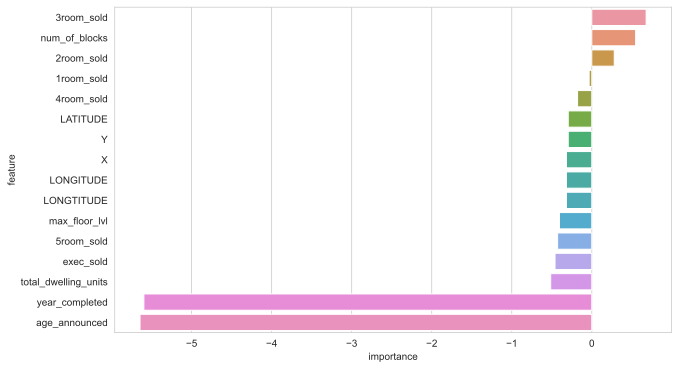

In [27]:
plt.figure(figsize=(10,6), dpi=300)

sns.set_style("whitegrid")
sns.barplot("importance", "feature", data=features)

# LOOKING AT THE FALSE NEGATIVES
Our model only got 4 blocks wrong. Let's look at what those predictions were.

In [28]:
#CREATING A COLUMN IN X_test TO HOUSE OUR PREDICTIONS
X_test["lr_predictions"] = lr.predict(X_ss_test)

/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
#CREATING A COLUMN IN X_test TO HOUSE is_demolished BOOLEANS
X_test["is_demolished"] = y_test

/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
#CREATING A MASK TO IDENTIFY FALSE NEGATIVES
# I.E. MODEL THOUGHT THESE FLATS WERE STANDING, BUT THEY WERE DEMOLISHED
X_test[X_test["lr_predictions"] !=X_test["is_demolished"]]

,year_completed,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,total_dwelling_units,age_announced,num_of_blocks,X,Y,LATITUDE,LONGITUDE,LONGTITUDE,lr_predictions,is_demolished
174,1979.0,9.33,0.0,0.0,105.375,17.5,0.5,0.0,123.375,37.0,8.0,19798.963943,32163.394551,1.307148,103.759628,103.759628,0,1
172,1979.0,9.33,0.0,0.0,105.375,17.5,0.5,0.0,123.375,37.0,8.0,19722.708873,32281.695996,1.308218,103.758943,103.758943,0,1
168,1979.0,9.33,0.0,0.0,105.375,17.5,0.5,0.0,123.375,37.0,8.0,19754.958592,32365.168618,1.308973,103.759233,103.759233,0,1
173,1979.0,9.33,0.0,0.0,105.375,17.5,0.5,0.0,123.375,37.0,8.0,19769.642620,32220.491106,1.307664,103.759365,103.759365,0,1


In [31]:
# PEEKING AT DETAILS OF THE FALSE NEGATIVES
# WEST COAST IS ONE OF THE NEWER BLOCKS THAT WERE DEMOLISHED. 
# IT PROBABLY FELT THE BLOCK WAS TOO EARLY TO GO
before1984_blocks[before1984_blocks.index.isin([174, 172, 168, 173])]

,year_completed,blk_no,street,bldg_contract_town,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,...,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,LONGTITUDE
168,1979.0,514,west coast rd,cl,9.33,0.0,0.0,105.375,17.5,0.5,...,514,WEST COAST ROAD,WEST COAST PRIDE,514 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120514,120514,19754.958592,32365.168618,1.308973,103.759233,103.759233
172,1979.0,518,west coast rd,cl,9.33,0.0,0.0,105.375,17.5,0.5,...,518,WEST COAST ROAD,WEST COAST PRIDE,518 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120518,120518,19722.708873,32281.695996,1.308218,103.758943,103.758943
173,1979.0,519,west coast rd,cl,9.33,0.0,0.0,105.375,17.5,0.5,...,519,WEST COAST ROAD,WEST COAST PRIDE,519 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120519,120519,19769.642620,32220.491106,1.307664,103.759365,103.759365
174,1979.0,520,west coast rd,cl,9.33,0.0,0.0,105.375,17.5,0.5,...,520,WEST COAST ROAD,WEST COAST PRIDE,520 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120520,120520,19798.963943,32163.394551,1.307148,103.759628,103.759628


In [32]:
# AS WE CAN SEE FROM THIS, THE DEMOLISHED BLOCKS KINDA DETECTED THAT OUR FOUR BLOCKS WERE PART OF THIS CLUSTER
#OF OTHER WEST COAST BLOCKS THAT DID NOT GET DEMOLISHED. MAYBE IT LEARNT ABOUT THEM IN THE TRAINING SET
# TO ME, THIS IS A CLEAR SIGN THAT LOCATION MUST NOT BE ONE OF THE FEATURES. 
before1984_blocks[before1984_blocks.street.str.contains("west coast rd")]

,year_completed,blk_no,street,bldg_contract_town,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,...,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,LONGTITUDE
10600,1979.0,513,west coast rd,cl,14.00,0.0,0.0,178.000,26.0,1.0,...,513,WEST COAST ROAD,WEST COAST PRIDE,513 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120513,120513,19869.062565,32331.276074,1.308666,103.760258,103.760258
10601,1979.0,514,west coast rd,cl,12.00,0.0,0.0,110.000,22.0,0.0,...,514,WEST COAST ROAD,WEST COAST PRIDE,514 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120514,120514,19754.958592,32365.168618,1.308973,103.759233,103.759233
10602,1979.0,515,west coast rd,cl,14.00,0.0,0.0,124.000,26.0,2.0,...,515,WEST COAST ROAD,WEST COAST PRIDE,515 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120515,120515,19816.295965,32299.954249,1.308383,103.759784,103.759784
10603,1979.0,516,west coast rd,cl,2.00,0.0,0.0,3.000,0.0,0.0,...,516,WEST COAST ROAD,WEST COAST PRIDE,516 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120516,120516,19889.910456,32276.164855,1.308168,103.760446,103.760446
10604,1979.0,517,west coast rd,cl,2.00,0.0,0.0,0.000,0.0,0.0,...,517,WEST COAST ROAD,WEST COAST PRIDE,517 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120517,120517,19857.825213,32199.783054,1.307477,103.760157,103.760157
10605,1979.0,518,west coast rd,cl,12.00,0.0,0.0,146.000,22.0,1.0,...,518,WEST COAST ROAD,WEST COAST PRIDE,518 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120518,120518,19722.708873,32281.695996,1.308218,103.758943,103.758943
10606,1979.0,519,west coast rd,cl,12.00,0.0,0.0,150.000,22.0,0.0,...,519,WEST COAST ROAD,WEST COAST PRIDE,519 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120519,120519,19769.642620,32220.491106,1.307664,103.759365,103.759365
10607,1979.0,520,west coast rd,cl,12.00,0.0,0.0,132.000,22.0,0.0,...,520,WEST COAST ROAD,WEST COAST PRIDE,520 WEST COAST ROAD WEST COAST PRIDE SINGAPORE 120520,120520,19798.963943,32163.394551,1.307148,103.759628,103.759628
10608,1979.0,701,west coast rd,cl,12.00,0.0,0.0,190.000,22.0,3.0,...,701,WEST COAST ROAD,HDB-CLEMENTI,701 WEST COAST ROAD HDB-CLEMENTI SINGAPORE 120701,120701,19993.499180,32214.717579,1.307612,103.761376,103.761376
10609,1979.0,702,west coast rd,cl,13.00,0.0,0.0,166.000,24.0,1.0,...,702,WEST COAST ROAD,HDB-CLEMENTI,702 WEST COAST ROAD HDB-CLEMENTI SINGAPORE 120702,120702,19963.603220,32176.568327,1.307267,103.761108,103.761108


# USING OUR MODEL ON UNSEEN DATA
With our model trained up, let's try to use it on all standing blocks built after 1984. 

The results of this predictions can be written out in this manner...
Based on the the Housing Development Board's previous demolition strategy, which blocks might make the cut to be demolished in 2020. 

*Assumptions: We will not include the pre-1984 blocks that "survived". (We should do some EDA to see whether surviving means you survive forever)*

In [33]:
#OUR UNSEEN TEST SET: WILL BE WHAT WAS BUILT FROM 1984
from1984_blocks = stand_blocks_latlon[stand_blocks_latlon["year_completed"]>1983]

In [34]:
#PREPPING A UNSEEN DATA SET OF BLOCKS THAT WE KNOCKED DOWN ONLY AFTER 1984
from1984_blocks_prep =from1984_blocks.select_dtypes(exclude=['object'])
X_val = from1984_blocks_prep.drop('is_demolished',axis=1)


In [35]:
#CHEATING ALERT

#I'm tweaking the year completed or else the model does not predict anything. 3

# THIS SHOULD NOT BE THE WAY, BUT I'M JUST TRYING TO SHOE HORN THE SCALE OF THE YEARS
# THIS SHOULD RIGHTLY BE DONE USING MINMAX SCALER I THINK
# EITHER THAT OR WE ADD A FUNCTION TO ASK WHAT YEAR ARE WE CHECKING THIS IN, THEN WE ADD THE YEAR TO AGE ANNOUNCED
X_val.year_completed -= 3

In [36]:
X_val.describe()

,year_completed,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,total_dwelling_units,age_announced,num_of_blocks,X,Y,LATITUDE,LONGITUDE,LONGTITUDE
count,9574.000000,9574.000000,9574.0,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000,9574.000000
mean,1994.835388,12.084291,0.0,1.950178,8.808231,36.505745,21.947357,6.484333,78.879779,22.164612,12.786296,28617.059813,39601.613498,1.374416,103.838863,103.838863
std,10.655927,7.208763,0.0,12.739789,23.022822,39.441684,29.620274,19.285566,58.832966,10.655927,10.170102,8436.847694,4434.326315,0.040103,0.075811,0.075811
min,1981.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,11519.146494,28252.740484,1.271782,103.685228,103.685228
25%,1985.000000,6.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,16.000000,5.000000,21136.986254,36589.481257,1.347174,103.771651,103.771651
50%,1993.000000,12.000000,0.0,0.000000,0.000000,30.000000,0.000000,0.000000,87.000000,24.000000,10.000000,29217.186441,39578.183838,1.374205,103.844256,103.844256
75%,2001.000000,16.000000,0.0,0.000000,0.000000,60.000000,42.000000,0.000000,112.000000,32.000000,17.000000,35411.789175,42283.820877,1.398673,103.899920,103.899920
max,2016.000000,50.000000,0.0,181.000000,192.000000,308.000000,164.000000,135.000000,584.000000,36.000000,53.000000,45247.320556,48703.591803,1.456732,103.988299,103.988299


In [37]:
X_ss_val = ss.transform(X_val)

In [38]:
lr.predict(X_ss_val)

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
# CREATING A PREDICTIONS COLUMN
from1984_blocks["predictions"] = lr.predict(X_ss_val)

/Users/samuelhe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
from1984_blocks["predictions"].sum()

19

In [41]:
from1984_blocks[from1984_blocks["predictions"]==1]

,year_completed,blk_no,street,bldg_contract_town,max_floor_lvl,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,...,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,LONGTITUDE,predictions
2031,2017.0,440a,bt batok west ave 8,bb,16.0,0.0,120.0,45.0,0.0,0.0,...,BUKIT BATOK WEST AVENUE 8,WEST RIDGES @ BUKIT BATOK,440A BUKIT BATOK WEST AVENUE 8 WEST RIDGES @ BUKIT BATOK SINGAPORE 651440,651440,17478.091408,37479.786946,1.355227,103.738772,103.738772,1
3653,2018.0,150a,corporation dr,jw,20.0,0.0,171.0,95.0,0.0,0.0,...,CORPORATION DRIVE,YUNG HO SPRING II,150A CORPORATION DRIVE YUNG HO SPRING II SINGAPORE 611150,611150,15653.415218,34327.777039,1.326720,103.722378,103.722378,1
5828,1999.0,607a,jurong west st 65,jw,1.0,0.0,0.0,0.0,0.0,0.0,...,JURONG WEST STREET 65,NIL,607A JURONG WEST STREET 65 SINGAPORE 641607,641607,13155.796698,35605.738257,1.338277,103.699935,103.699935,1
5835,1999.0,617a,jurong west st 65,jw,5.0,0.0,0.0,0.0,0.0,0.0,...,JURONG WEST STREET 65,MULTI STOREY CAR PARK,617A JURONG WEST STREET 65 MULTI STOREY CAR PARK SINGAPORE 641617,641617,13173.514697,35893.443796,1.340878,103.700094,103.700094,1
5842,1999.0,627a,jurong west st 65,jw,1.0,0.0,0.0,0.0,0.0,0.0,...,JURONG WEST STREET 65,NIL,627A JURONG WEST STREET 65 SINGAPORE 641627,641627,13046.681403,35978.044778,1.341643,103.698954,103.698954,1
5845,1999.0,629a,jurong west st 65,jw,5.0,0.0,0.0,0.0,0.0,0.0,...,JURONG WEST STREET 65,MULTI STOREY CAR PARK,629A JURONG WEST STREET 65 MULTI STOREY CAR PARK SINGAPORE 641629,641629,13108.473643,36128.146312,1.343001,103.699509,103.699509,1
5848,1999.0,635a,jurong west st 65,jw,5.0,0.0,0.0,0.0,0.0,0.0,...,JURONG WEST STREET 65,NIL,635A JURONG WEST STREET 65 SINGAPORE 641635,641635,13026.992383,36063.247033,1.342414,103.698777,103.698777,1
5849,1999.0,657,jurong west st 65,jw,6.0,0.0,0.0,0.0,0.0,0.0,...,JURONG WEST STREET 65,MULTI STOREY CAR PARK,657 JURONG WEST STREET 65 MULTI STOREY CAR PARK SINGAPORE 640657,640657,13265.102014,35289.561169,1.335417,103.700917,103.700917,1
5851,1999.0,659,jurong west st 65,jw,5.0,0.0,0.0,0.0,0.0,0.0,...,JURONG WEST STREET 65,MULTI STOREY CAR PARK,659 JURONG WEST STREET 65 MULTI STOREY CAR PARK SINGAPORE 640659,640659,13400.593435,35490.248041,1.337232,103.702135,103.702135,1
5856,1999.0,667e,jurong west st 65,jw,1.0,0.0,0.0,0.0,0.0,0.0,...,JURONG WEST STREET 65,NIL,667E JURONG WEST STREET 65 SINGAPORE 645667,645667,13442.386771,36021.627103,1.342038,103.702510,103.702510,1


# CONCLUSION

- The model, with some "cheating" is predicting a whole bunch of jurong west blocks as potential demolished blocks.
- If we look closely at the blocks, they are mostly short blocks. This is not bad because at least its making some kind of decision based on height of blocks. 

- I think the location data is corupting the results though...cos all in jurong.

# PLS IGNORE EVERYTHING BELOW THIS LINE

## OTHER THINGS WE NEED TO TRY
- Other models
- Look at the TP, FP, TN, FNs - My feeling is that these are important. Even what the model sees as wrong is important

## FEATURES THAT WE CAN ADD
- proximity to Airbases(means cannot build higher)
- proximity to multistorey carparks (means that place has already been used efficiently) Important that the year the multistorey carpark was built must be consider)
- There is a carparks dataset online
- proximity to MRT(Assumption that the HDB wants to maximize the amount of flats clustered around an MRT station. 
- Density(how many flats built witin XX area around it)
- the average height of the five closest blocks to it that's built within 5 years of the same building




## IGNORE EVERYTHING BELOW

In [42]:
gb=GridSearchCV(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1),
                {"max_iter": [100, 200, 350]}, scoring='roc_auc')            
gb.fit(X_ss_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'max_iter': [100, 200, 350]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='roc_auc',
             verbose=0)

In [43]:
features=gb.best_estimator_

In [44]:
features

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# PLS IGNORE

# ROUGH PAPER BELOW THIS LINE

---

In [45]:
#Creating a geospatial plot with the data above...
#...with hues and markersize showing which are the worst-hit streets
# mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")

# aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
# #Chicago_lon_lat_box = (-88, -87.5, 41.6, 42.1)

# lon_lat_box = (103.59, 104.14, 1.17, 1.46)

plt.figure(figsize=(20,14), dpi=500)

# plt.imshow(mapdata, 
#           cmap=plt.get_cmap('gray'),
#           extent=lon_lat_box,
#           aspect=aspect)
# plt.title('West Nile Virus repeatedly found on same sites in different years in Chicago', fontsize=12, c="darkred");

sns.scatterplot(demo_blocks_clean['LONGITUDE'], demo_blocks_clean['LATITUDE'], marker='P', 
                hue=demo_blocks_clean["year_completed"],
               sizes=(2, 500), palette="rainbow", alpha=0.5, legend="full");

NameError: name 'demo_blocks_clean' is not defined

<Figure size 10000x7000 with 0 Axes>

In [ ]:

import json
from shapely.geometry import shape, GeometryCollection

with open("../data/singapore-map-polygon/national-map-polygon-geojson.geojson") as f:
  features = json.load(f)["features"]

# NOTE: buffer(0) is a trick for fixing scenarios where polygons have overlapping coordinates 
GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])